# Frozen lake : Reinforcement Learning
![ Frozen lake](images/frozen_lake.gif) 

For the first part of the project we will tackle the frozen lake Envirement which involves crossing a frozen lake from the start position to a predetermined goal without falling into any holes. The solution isn't deterministic as the player can slip on the ice.
 
## Envirement description : 

### 1. Action Space
The action shape is as follows : 
- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

### 2. Observation Space
The observation is a value representing the player’s current position= and it ranges from 0 to the map's width*height-1.

### 3. Starting State
The episode starts with the player in state [0] at the location [0, 0] in the map.

### 4. Rewards : 
Reward can be defined as follows : 
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

### 5. Episode End : 
The episode ends if the following happens:
- Termination:
    - The player moves into a hole.
    - The player reaches the goal at max(width) * max(height) - 1 (location [width-1, height-1]).
- Truncation :
    - The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.


Uploading the necessary libraries and modules needed for our experiment.

In [1]:
import gymnasium as gym
#from tools.qlearning import *
import numpy as np
import matplotlib.pyplot   as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

We will experiment with both conditions `is_slippery=True` and `is_slippery=False`. The last condition means that the agent realizes the action it has decided, and thus that the policy in this case is deterministic. On the contrary, the conditions `is_slippery = True` means that the agent actually has a probability $\frac{1}{3}$ to go on the direction decided by the action, and a probability $\frac{1}{3}$ to go on one of the perpendicular direction. In this case, the policy is a stochastic one. We will first start with the deterministic one, and then we will work with the stochastic one.

In [2]:
# To speed up the process we will set the render_mode as None.
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)
num_actions = env.action_space.n
num_states = env.observation_space.n

First, let's upload the optimal policy that we built ourselves, by looking at the map.

In [3]:
deterministic_q_table = np.load(".\data\deterministic_q_table.npy")
deterministic_q_table

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0]], dtype=int64)

# 1. Algorithms

We first define a general function here, that will be used in many of our algorithms. As we know, when using the `np.argmax` function in Python, it only returns the first argument maximizing the quantity, even though there may be other arguments also maximizing it. To avoid this thing, we will implement a function that get all the arguments maximizing the quantity, and choose randomly between them all.

In [25]:
def action_choice_max(tab) :
    max_indices = np.argwhere(tab == np.amax(tab))
    max_indices = max_indices.reshape(len(max_indices),)
    action = np.random.choice(max_indices)
    return action

### 1.1 Q-Learning

In [27]:
import numpy as np
from tqdm import *
def q_train(env, alpha=0.01, gamma=0.9, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm 
    
    """
    rewards =[]
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            a = action_choice_max(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, truncated , info = env.step(a) # Take action a and observe the reward and next state s_new and reward r
            #print(s, a, r, s_new, done)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s = s_new
            total_reward = total_reward + r

            # if s is a terminal state then go to next episode;
            if done or truncated: 
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))

    return q_table



In [28]:
q_table = q_train(env)

# q_table = q_train(env, weights="data/q_table.npy")
# np.save('data/q_table.npy', q_table)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 873.28it/s]

Finished Q-learning algorithm.
Average reward is : 0.9908


### 1.2 Q-Learning ( $\epsilon-greedy$)

$\epsilon-greedy$ is an good strategy for balancing exploration and exploitation.

In [29]:
def q_train_greedy(env, alpha=0.99, gamma=0.9, epsilon=0.5, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm (epsilon-greedy)
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = action_choice_max(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                rewards.append(total_reward) 
                break
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [30]:
q_table_greedy = q_train_greedy(env)
# q_table_greedy = q_train_greedy(env,weights="data/q_table_greedy.npy")
# np.save('data/q_table_greedy.npy', q_table_greedy)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:13<00:00, 752.99it/s]

Finished Q-learning algorithm.
Average reward is : 0.4009



### 1.3 Q-learning epsilon decay
The concept of decay : 
During the lifecycle of an agent that does not have sufficient information on its environment, exploration is more important than exploitation. Once the agent has enough information about the environment, we can then start to exploit that information to improve the agent's performance [Source](https://arxiv.org/pdf/1910.13701.pdf). That's why we'll use the concept of decay by starting with a maximum value of epsilon and then decaying it gradually across every episode. 



In [31]:
def q_train_greedy_decay(env, alpha=0.8, gamma=0.9,min_epsilon=0.005, decay_rate=0.001, max_n_steps=100, n_episodes=10000, weights=None):
    """ Q-learning algorithm (epsilon-greedy) with exponential epsilon decay
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []
    epsilon = 1
    
    print("Starting Q-learning algorithm...")
    for episode in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = action_choice_max(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)

            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                # Epsilon exponential decay
                epsilon = min_epsilon + (1-min_epsilon)*np.exp(-decay_rate*episode)
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [32]:
q_table_greedy_decay=q_train_greedy_decay(env)
# q_table_greedy_decay=q_train_greedy_decay(env, weights="data/q_table_greedy_decay.npy")
# np.save("data/q_table_greedy_decay.npy", q_table_greedy)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:13<00:00, 752.65it/s]

Finished Q-learning algorithm.
Average reward is : 0.8819


### 1.4 SARSA

In [33]:
def sarsa_train(env, alpha=0.1, gamma=1, epsilon=0.5, episodes=10000, steps=1000) :
    "SARSA algorithme : les paramètres par défaut n'ont pas été ajustés."
    
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    q = np.zeros((num_states, num_actions))

    for ep in trange(episodes) : 
        
        env.reset()
        state = env.s

        if np.random.uniform() < epsilon :
            action = env.action_space.sample()
        else :
            action = action_choice_max(q[state, :])
            
        for _ in range(steps) :
            nw_state, reward, terminated, truncated, info = env.step(action)
            
            if np.random.uniform() < epsilon :
                nw_action = env.action_space.sample()
            else :
                nw_action = action_choice_max(q[nw_state, :])
                
            q[state, action] = (1-alpha)*q[state, action] + \
                alpha*(reward + gamma*q[nw_state, nw_action])
                
            state = nw_state
            action = nw_action
            
            if terminated or truncated :
                break
    
    env.close()
    
    return q

In [34]:
sarsa_table = sarsa_train(env)

100%|██████████| 10000/10000 [00:13<00:00, 764.98it/s]


## 2. Results with condition `is_slippery=False`

### 2.1. Algorithms' results

In [35]:
def agent_play(env,q_table, max_n_episodes=10000, max_steps=100):
    count = 0
    rewards = []
    num_steps = []
    for _ in trange(max_n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_steps):
            a = np.argmax(q_table[s])
            s, r, done, tr,_ = env.step(a)
            total_reward+=r
            if done or tr: 
                rewards.append(total_reward)
                num_steps.append(i+1)
                count+=1
                break
    success_rate = np.mean(rewards)
    avg_num_steps = np.mean(num_steps)
    print(f'Success rate is = {100*success_rate} %')
    print(f'Average number of steps before end (success or fall) = {avg_num_steps}')
    return rewards, success_rate, avg_num_steps

In [36]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env, q_table=sarsa_table)


100%|██████████| 10000/10000 [00:03<00:00, 3277.39it/s]


Success rate is = 100.0 %
Average number of steps before end (success or fall) = 6.0


100%|██████████| 10000/10000 [00:03<00:00, 3249.66it/s]


Success rate is = 100.0 %
Average number of steps before end (success or fall) = 6.0


100%|██████████| 10000/10000 [00:03<00:00, 3222.99it/s]


Success rate is = 100.0 %
Average number of steps before end (success or fall) = 6.0


100%|██████████| 10000/10000 [00:03<00:00, 3275.65it/s]


Success rate is = 100.0 %
Average number of steps before end (success or fall) = 6.0


100%|██████████| 10000/10000 [00:03<00:00, 3265.35it/s]

Success rate is = 100.0 %
Average number of steps before end (success or fall) = 6.0


> Let's make some comments.

In the deterministic case, an optimal policy always exists. 
There is no surprise that the deterministic table provided at the beginning has a 100% success rate. The agent simply follows the path by selecting the action corresponding to the ones in the table.

The basic Q-learning algorithm has a 100% success rate. It is interesting to note that at first, we didn't use the function randomly selecting an action between all the arguments maximizing the state-action value function. In this case, we had a 0% success rate. It would always be this way, as soon as we start with an initial table filled with 0. Indeed, since Python `np.argmax` function always gives the first action maximizing, and since we start with everything at 0, this function will always return 0, meaning that the agent will always try to go left. Due to `is_slippery = False`, the agent will always try to go left, thus it will never move. It will never reach the goal and never get any reward, and the updating policy stage will never modify any value. We also tried to start with a complete random q matrix, but the agent still can't manage : with a complete random policy, the probability to get to the goal is really low. But with the function `action_choice_max`, we include some randomness in the choice of the action, we explore more, and the agent can learn how to reach the goal.

This problem is also solved by using the $\epsilon$-greedy Q-learning algorithms, and also the SARSA algorithm. Since it add some randomness in the actions' choice, the agent won't always try to go the same way and will reach the goal eventually. Once it has, it can start learning. Please note that the $\epsilon$-greedy Q-learning algorithm, with no decay, is very sensitive to the value of $\epsilon$. A too small value will hardly change anything, compared to the basic Q-learning, and a too high will only create randomness.

### 2.2. Comparison

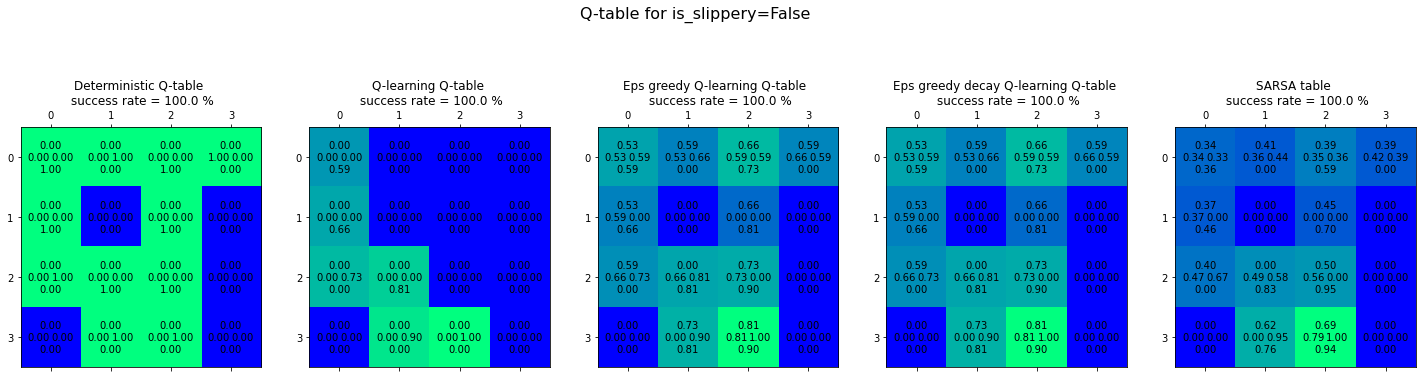

In [37]:
deterministic_q_table = np.load("data/deterministic_q_table.npy")

fig, ax = plt.subplots(1, 5)
fig.suptitle("Q-table for is_slippery=False", fontsize=16)

fig.set_size_inches(25, 7)
# im = Image.open('images/frozen_lake.jpg')
plt.title("Q-table of the game")

# Creating the heat maps
map_q = np.sum(q_table, axis = 1)
map_q= map_q.reshape(4, 4)

map_d = np.sum(deterministic_q_table, axis = 1)
map_d= map_d.reshape(4, 4)

map_g = np.sum(q_table_greedy, axis = 1)
map_g= map_g.reshape(4, 4)

map_e = np.sum(q_table_greedy_decay, axis = 1)
map_e= map_e.reshape(4, 4)

map_s = np.sum(sarsa_table, axis = 1)
map_s= map_s.reshape(4, 4)


# ax[0].imshow(im, alpha=1)
# ax[1].imshow(im, alpha=1)

ax[0].matshow(map_d, cmap='winter')
ax[1].matshow(map_q, cmap='winter')
ax[2].matshow(map_g, cmap='winter')
ax[3].matshow(map_e, cmap='winter')
ax[4].matshow(map_s, cmap='winter')

pos=[0,1,2,3]

deterministic_q_table_reshaped=deterministic_q_table.reshape((4,4,4))
q_table_reshaped=q_table.reshape((4,4,4))
greedy_reshaped=q_table_greedy.reshape((4,4,4))
q_table_greedy_decay_reshaped =q_table_greedy_decay.reshape((4,4,4))
sarsa_reshaped =sarsa_table.reshape((4,4,4))


deviation = 0.2
for i in pos: # rows
    for j in pos: # cols

        ax[0].text(j-deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[0].text(j, i+deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[0].text(j+deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[0].text(j, i-deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[0].set_title(f"Deterministic Q-table \n success rate = {100*round(success_rate_d,2)} %")

        ax[1].text(j-deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[1].text(j, i+deviation, '{:0.2f}'.format(q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[1].text(j+deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[1].text(j, i-deviation, '{:0.2f}'.format(q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[1].set_title(f"Q-learning Q-table \n success rate = {100*round(success_rate_q,2)} %")

        ax[2].text(j-deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[2].text(j, i+deviation, '{:0.2f}'.format(greedy_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[2].text(j+deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[2].text(j, i-deviation, '{:0.2f}'.format(greedy_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[2].set_title(f"Eps greedy Q-learning Q-table  \n success rate = {100*round(success_rate_q_greedy,2)} %")


        ax[3].text(j-deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[3].text(j, i+deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[3].text(j+deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[3].text(j, i-deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[3].set_title(f"Eps greedy decay Q-learning Q-table \n success rate = {100*round(success_rate_q_greedy_decay,2)} %")

        ax[4].text(j-deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[4].text(j, i+deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[4].text(j+deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[4].text(j, i-deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[4].set_title(f"SARSA table \n success rate = {100*round(success_rate_sarsa,2)} %")
plt.show()

Then we'll define a play function for our game to test the performance

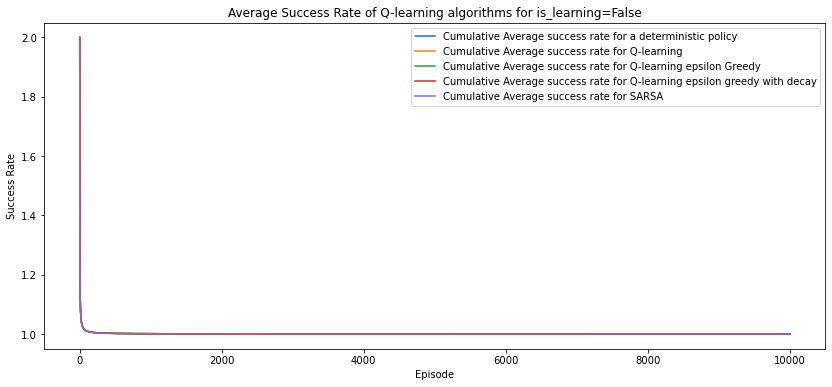

In [38]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-learning epsilon greedy with decay")
plt.plot(np.arange(len(rewards_sarsa)), np.cumsum(rewards_sarsa)/np.arange(len(rewards_sarsa)), label="Cumulative Average success rate for SARSA")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Success Rate of Q-learning algorithms for is_learning=False')
plt.legend()
plt.show()

## 3. Results with the condition `is_slippery = True`

In [39]:
env_slip = gym.make("FrozenLake-v1", is_slippery=True, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)

### 3.1. Algorithms' results

In [40]:
q_table = q_train(env_slip)
q_table_greedy = q_train_greedy(env_slip)
q_table_greedy_decay=q_train_greedy_decay(env_slip, alpha = 0.1, gamma = 0.99, min_epsilon=0.5)
sarsa_table = sarsa_train(env_slip)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 789.30it/s]


Finished Q-learning algorithm.
Average reward is : 0.0432
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 630.53it/s]


Finished Q-learning algorithm.
Average reward is : 0.0304
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:19<00:00, 511.70it/s]


Finished Q-learning algorithm.
Average reward is : 0.0564


100%|██████████| 10000/10000 [00:17<00:00, 579.65it/s]


In [41]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env_slip, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env_slip, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env_slip, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env_slip, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env_slip, q_table=sarsa_table)

100%|██████████| 10000/10000 [00:02<00:00, 3487.49it/s]


Success rate is = 4.91 %
Average number of steps before end (success or fall) = 5.1212


100%|██████████| 10000/10000 [00:03<00:00, 3003.16it/s]


Success rate is = 4.1000000000000005 %
Average number of steps before end (success or fall) = 6.155


100%|██████████| 10000/10000 [00:03<00:00, 2725.33it/s]


Success rate is = 3.9 %
Average number of steps before end (success or fall) = 7.2516


100%|██████████| 10000/10000 [00:19<00:00, 525.04it/s]


Success rate is = 70.54 %
Average number of steps before end (success or fall) = 41.7833


100%|██████████| 10000/10000 [00:12<00:00, 826.50it/s]

Success rate is = 39.71 %
Average number of steps before end (success or fall) = 24.406


> Let's make some comments.

Keep in mind that we are in the situation where `is_slippery = True`, meaning that when the agent choose to go one way, the probability that he really goes this way is $\frac{1}{3}$, and he could go on a perpendicular direction with probability $\frac{1}{3}$, for each perpendicular direction. In this case, it is impossible to reach 100% success. 
The deterministic table, with only ones or zeros, has no flexibility : the agent always want to use the same path, but due to the randomness, he almost always fails.

With the basic Q-learning algorithm, we will always get a 0% success rate if we start with a initial q-table filled with 0. Indeed, since Python `np.argmax` function always give the first action maximizing, and since we start with everything at 0, this function will always return 0, meaning that the agent will always try to go left. Due to `is_slippery = True`, the agent may or may not move (going left, when starting, is not possible), but won't get any reward (no reward are granted until the goal is reached). Thus, at next step, the agent will again try to go left (the q-table updating stage won't modify any values). With such a policy, the agent is unlikely to ever reach the goal. Using the `action_max_function` we implemented earlier add some randomness and increase the probability to reach the goal, but as we can see, it is far from being sufficient.

The two other Q-learning algorithms also help avoid this problem, by allowing the agent taking random actions, and not always the same one "going left". This increases the probability to reach the goal. The SARSA algorithm also uses randomness to choose actions. The parameters, such as `gamma`, `epsilon` or `alpha` may have great influence on the results. Some parameters tuning may be useful in this case.

### 3.2. Hyperparameter tuning

Considering that the results may be highly influenced by the parameters, let's try some tuning, for the $\epsilon$-greedy decay Q-learning and SARSA algorithms.

In [42]:
# Qlearning optimization
alpha = [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 0.99]
gamma = [0.5, 0.8, 0.9, 0.95, 0.99, 1]
epsilon = [0.01, 0.05, 0.1, 0.5]

alphas=[]
success_rates = []
gammas=[]
epsilons=[]
rewards =[]
for al in alpha :
    for ga in gamma :
        for ep in epsilon :
            q_table = q_train_greedy_decay(env_slip, alpha=al, gamma=ga, min_epsilon=ep)
            reward, success_rate, avg_nb_steps = agent_play(env_slip, q_table)
            success_rates.append(success_rate)
            alphas.append(al)
            gammas.append(ga)
            epsilons.append(ep)
            rewards.append(reward)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 648.34it/s]


Finished Q-learning algorithm.
Average reward is : 0.042


100%|██████████| 10000/10000 [00:03<00:00, 2742.52it/s]


Success rate is = 4.5600000000000005 %
Average number of steps before end (success or fall) = 5.9176
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:27<00:00, 367.81it/s]


Finished Q-learning algorithm.
Average reward is : 0.06930693069306931


100%|██████████| 10000/10000 [00:04<00:00, 2139.88it/s]


Success rate is = 5.9799999999999995 %
Average number of steps before end (success or fall) = 9.508
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:16<00:00, 600.30it/s]


Finished Q-learning algorithm.
Average reward is : 0.049


100%|██████████| 10000/10000 [00:07<00:00, 1324.21it/s]


Success rate is = 12.64 %
Average number of steps before end (success or fall) = 15.5993
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 779.07it/s]


Finished Q-learning algorithm.
Average reward is : 0.0309


100%|██████████| 10000/10000 [00:07<00:00, 1390.52it/s]


Success rate is = 11.84 %
Average number of steps before end (success or fall) = 14.6655
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:16<00:00, 606.24it/s]


Finished Q-learning algorithm.
Average reward is : 0.0614


100%|██████████| 10000/10000 [00:04<00:00, 2340.00it/s]


Success rate is = 7.39 %
Average number of steps before end (success or fall) = 8.0571
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 638.21it/s]


Finished Q-learning algorithm.
Average reward is : 0.029


100%|██████████| 10000/10000 [00:03<00:00, 2706.75it/s]


Success rate is = 3.05 %
Average number of steps before end (success or fall) = 6.9396
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:25<00:00, 396.38it/s]


Finished Q-learning algorithm.
Average reward is : 0.11122224444888978


100%|██████████| 10000/10000 [00:09<00:00, 1027.68it/s]


Success rate is = 27.21 %
Average number of steps before end (success or fall) = 20.453
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 658.43it/s]


Finished Q-learning algorithm.
Average reward is : 0.0412


100%|██████████| 10000/10000 [00:18<00:00, 537.88it/s]


Success rate is = 61.47 %
Average number of steps before end (success or fall) = 39.0144
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 906.09it/s]


Finished Q-learning algorithm.
Average reward is : 0.0398


100%|██████████| 10000/10000 [00:02<00:00, 3618.68it/s]


Success rate is = 4.68 %
Average number of steps before end (success or fall) = 5.2768
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:14<00:00, 702.00it/s]


Finished Q-learning algorithm.
Average reward is : 0.0254


100%|██████████| 10000/10000 [00:03<00:00, 2687.22it/s]


Success rate is = 2.67 %
Average number of steps before end (success or fall) = 7.3304
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 802.12it/s]


Finished Q-learning algorithm.
Average reward is : 0.0357


100%|██████████| 10000/10000 [00:06<00:00, 1549.75it/s]


Success rate is = 9.43 %
Average number of steps before end (success or fall) = 12.5471
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 641.57it/s]


Finished Q-learning algorithm.
Average reward is : 0.0447


100%|██████████| 10000/10000 [00:13<00:00, 758.11it/s]


Success rate is = 34.06 %
Average number of steps before end (success or fall) = 28.0587
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:25<00:00, 395.14it/s]


Finished Q-learning algorithm.
Average reward is : 0.1164


100%|██████████| 10000/10000 [00:06<00:00, 1437.46it/s]


Success rate is = 13.65 %
Average number of steps before end (success or fall) = 13.4917
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:13<00:00, 725.59it/s]


Finished Q-learning algorithm.
Average reward is : 0.0521


100%|██████████| 10000/10000 [00:03<00:00, 2724.30it/s]


Success rate is = 6.03 %
Average number of steps before end (success or fall) = 7.3348
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:20<00:00, 494.74it/s]


Finished Q-learning algorithm.
Average reward is : 0.082


100%|██████████| 10000/10000 [00:08<00:00, 1169.32it/s]


Success rate is = 18.42 %
Average number of steps before end (success or fall) = 18.152
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 565.51it/s]


Finished Q-learning algorithm.
Average reward is : 0.0353


100%|██████████| 10000/10000 [00:17<00:00, 581.67it/s]


Success rate is = 39.0 %
Average number of steps before end (success or fall) = 33.6676
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:23<00:00, 433.43it/s]


Finished Q-learning algorithm.
Average reward is : 0.0805


100%|██████████| 10000/10000 [00:06<00:00, 1625.92it/s]


Success rate is = 10.13 %
Average number of steps before end (success or fall) = 12.3642
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 644.40it/s]


Finished Q-learning algorithm.
Average reward is : 0.0626


100%|██████████| 10000/10000 [00:04<00:00, 2407.14it/s]


Success rate is = 8.200000000000001 %
Average number of steps before end (success or fall) = 8.1339
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 979.89it/s]


Finished Q-learning algorithm.
Average reward is : 0.0244


100%|██████████| 10000/10000 [00:02<00:00, 3973.74it/s]


Success rate is = 2.59 %
Average number of steps before end (success or fall) = 4.7197
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:16<00:00, 614.23it/s]


Finished Q-learning algorithm.
Average reward is : 0.0425


100%|██████████| 10000/10000 [00:16<00:00, 611.33it/s]


Success rate is = 41.370000000000005 %
Average number of steps before end (success or fall) = 32.8726
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 560.71it/s]


Finished Q-learning algorithm.
Average reward is : 0.0765


100%|██████████| 10000/10000 [00:05<00:00, 1982.43it/s]


Success rate is = 8.85 %
Average number of steps before end (success or fall) = 8.2032
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:13<00:00, 742.95it/s]


Finished Q-learning algorithm.
Average reward is : 0.0447


100%|██████████| 10000/10000 [00:03<00:00, 3139.41it/s]


Success rate is = 5.319999999999999 %
Average number of steps before end (success or fall) = 6.2037
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:16<00:00, 618.77it/s]


Finished Q-learning algorithm.
Average reward is : 0.0599


100%|██████████| 10000/10000 [00:05<00:00, 1685.75it/s]


Success rate is = 11.14 %
Average number of steps before end (success or fall) = 11.7151
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 571.69it/s]


Finished Q-learning algorithm.
Average reward is : 0.039


100%|██████████| 10000/10000 [00:17<00:00, 576.93it/s]


Success rate is = 31.230000000000004 %
Average number of steps before end (success or fall) = 36.0228
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:22<00:00, 443.12it/s]


Finished Q-learning algorithm.
Average reward is : 0.09340934093409341


100%|██████████| 10000/10000 [00:04<00:00, 2179.34it/s]


Success rate is = 6.4399999999999995 %
Average number of steps before end (success or fall) = 8.923
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:22<00:00, 435.05it/s]


Finished Q-learning algorithm.
Average reward is : 0.09810981098109811


100%|██████████| 10000/10000 [00:03<00:00, 2623.60it/s]


Success rate is = 6.419999999999999 %
Average number of steps before end (success or fall) = 7.2054
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 573.15it/s]


Finished Q-learning algorithm.
Average reward is : 0.0735073507350735


100%|██████████| 10000/10000 [00:03<00:00, 3293.03it/s]


Success rate is = 6.08 %
Average number of steps before end (success or fall) = 5.58
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 781.92it/s]


Finished Q-learning algorithm.
Average reward is : 0.0319


100%|██████████| 10000/10000 [00:12<00:00, 799.68it/s]


Success rate is = 40.1 %
Average number of steps before end (success or fall) = 26.6069
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:44<00:00, 226.30it/s]


Finished Q-learning algorithm.
Average reward is : 0.28522440746343924


100%|██████████| 10000/10000 [00:14<00:00, 704.18it/s]


Success rate is = 43.81 %
Average number of steps before end (success or fall) = 30.0201
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:38<00:00, 260.68it/s]


Finished Q-learning algorithm.
Average reward is : 0.21768775694374812


100%|██████████| 10000/10000 [00:08<00:00, 1157.33it/s]


Success rate is = 17.119999999999997 %
Average number of steps before end (success or fall) = 16.7545
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:34<00:00, 286.11it/s]


Finished Q-learning algorithm.
Average reward is : 0.16753402722177743


100%|██████████| 10000/10000 [00:12<00:00, 823.49it/s]


Success rate is = 35.67 %
Average number of steps before end (success or fall) = 24.1611
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:20<00:00, 495.69it/s]


Finished Q-learning algorithm.
Average reward is : 0.0493


100%|██████████| 10000/10000 [00:14<00:00, 693.60it/s]


Success rate is = 41.07 %
Average number of steps before end (success or fall) = 26.6265
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:55<00:00, 180.82it/s]


Finished Q-learning algorithm.
Average reward is : 0.4283379303299622


100%|██████████| 10000/10000 [00:14<00:00, 690.90it/s]


Success rate is = 51.519999999999996 %
Average number of steps before end (success or fall) = 30.5142
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:49<00:00, 202.80it/s]


Finished Q-learning algorithm.
Average reward is : 0.332020202020202


100%|██████████| 10000/10000 [00:08<00:00, 1203.95it/s]


Success rate is = 21.21 %
Average number of steps before end (success or fall) = 15.8951
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:40<00:00, 247.10it/s]


Finished Q-learning algorithm.
Average reward is : 0.25858606145812413


100%|██████████| 10000/10000 [00:18<00:00, 526.98it/s]


Success rate is = 64.22 %
Average number of steps before end (success or fall) = 40.4973
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:18<00:00, 551.88it/s]


Finished Q-learning algorithm.
Average reward is : 0.0603


100%|██████████| 10000/10000 [00:21<00:00, 472.13it/s]


Success rate is = 63.83 %
Average number of steps before end (success or fall) = 41.3405
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [01:07<00:00, 148.23it/s]


Finished Q-learning algorithm.
Average reward is : 0.5226755021743632


100%|██████████| 10000/10000 [00:19<00:00, 522.41it/s]


Success rate is = 73.07000000000001 %
Average number of steps before end (success or fall) = 41.2805
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:56<00:00, 178.06it/s]


Finished Q-learning algorithm.
Average reward is : 0.4006109979633401


100%|██████████| 10000/10000 [00:15<00:00, 661.35it/s]


Success rate is = 44.6 %
Average number of steps before end (success or fall) = 30.0613
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:45<00:00, 219.40it/s]


Finished Q-learning algorithm.
Average reward is : 0.2976058187695727


100%|██████████| 10000/10000 [00:19<00:00, 508.25it/s]


Success rate is = 73.88 %
Average number of steps before end (success or fall) = 40.8473
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:20<00:00, 495.72it/s]


Finished Q-learning algorithm.
Average reward is : 0.0597


100%|██████████| 10000/10000 [00:19<00:00, 522.16it/s]


Success rate is = 67.08 %
Average number of steps before end (success or fall) = 37.775
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [01:03<00:00, 158.71it/s]


Finished Q-learning algorithm.
Average reward is : 0.5340037321169396


100%|██████████| 10000/10000 [00:20<00:00, 499.60it/s]


Success rate is = 72.88 %
Average number of steps before end (success or fall) = 41.59
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [01:01<00:00, 161.31it/s]


Finished Q-learning algorithm.
Average reward is : 0.4287186887949696


100%|██████████| 10000/10000 [00:20<00:00, 484.74it/s]


Success rate is = 73.44000000000001 %
Average number of steps before end (success or fall) = 44.7621
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:52<00:00, 190.75it/s]


Finished Q-learning algorithm.
Average reward is : 0.3225511138236192


100%|██████████| 10000/10000 [00:23<00:00, 425.29it/s]


Success rate is = 74.88 %
Average number of steps before end (success or fall) = 44.8105
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:25<00:00, 391.87it/s]


Finished Q-learning algorithm.
Average reward is : 0.058005800580058005


100%|██████████| 10000/10000 [00:25<00:00, 395.92it/s]


Success rate is = 73.87 %
Average number of steps before end (success or fall) = 44.563
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [01:06<00:00, 149.72it/s]


Finished Q-learning algorithm.
Average reward is : 0.5474929928371224


100%|██████████| 10000/10000 [00:21<00:00, 462.67it/s]


Success rate is = 72.5 %
Average number of steps before end (success or fall) = 41.5071
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [01:21<00:00, 123.24it/s]


Finished Q-learning algorithm.
Average reward is : 0.3165400350672122


100%|██████████| 10000/10000 [00:47<00:00, 211.09it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:55<00:00, 181.23it/s]


Finished Q-learning algorithm.
Average reward is : 0.2576533277609445


100%|██████████| 10000/10000 [00:48<00:00, 207.78it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:20<00:00, 480.59it/s]


Finished Q-learning algorithm.
Average reward is : 0.0554


100%|██████████| 10000/10000 [00:47<00:00, 209.12it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:20<00:00, 489.61it/s]


Finished Q-learning algorithm.
Average reward is : 0.09641928385677136


100%|██████████| 10000/10000 [00:03<00:00, 2539.79it/s]


Success rate is = 12.690000000000001 %
Average number of steps before end (success or fall) = 7.3901
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:20<00:00, 497.34it/s]


Finished Q-learning algorithm.
Average reward is : 0.0819


100%|██████████| 10000/10000 [00:08<00:00, 1221.91it/s]


Success rate is = 17.82 %
Average number of steps before end (success or fall) = 16.3234
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:18<00:00, 527.78it/s]


Finished Q-learning algorithm.
Average reward is : 0.0794


100%|██████████| 10000/10000 [00:09<00:00, 1059.19it/s]


Success rate is = 16.43 %
Average number of steps before end (success or fall) = 18.2378
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 902.31it/s]


Finished Q-learning algorithm.
Average reward is : 0.0359


100%|██████████| 10000/10000 [00:03<00:00, 2968.99it/s]


Success rate is = 6.08 %
Average number of steps before end (success or fall) = 8.821
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:42<00:00, 236.85it/s]


Finished Q-learning algorithm.
Average reward is : 0.24344945286617808


100%|██████████| 10000/10000 [00:11<00:00, 883.50it/s]


Success rate is = 22.33 %
Average number of steps before end (success or fall) = 24.5961
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:31<00:00, 314.43it/s]


Finished Q-learning algorithm.
Average reward is : 0.1933546837469976


100%|██████████| 10000/10000 [00:19<00:00, 516.15it/s]


Success rate is = 63.580000000000005 %
Average number of steps before end (success or fall) = 40.7686
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:29<00:00, 344.44it/s]


Finished Q-learning algorithm.
Average reward is : 0.15017508754377187


100%|██████████| 10000/10000 [00:06<00:00, 1530.96it/s]


Success rate is = 11.24 %
Average number of steps before end (success or fall) = 13.2572
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:18<00:00, 545.08it/s]


Finished Q-learning algorithm.
Average reward is : 0.0472


100%|██████████| 10000/10000 [00:12<00:00, 770.31it/s]


Success rate is = 45.15 %
Average number of steps before end (success or fall) = 27.3138
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:52<00:00, 189.95it/s]


Finished Q-learning algorithm.
Average reward is : 0.39601342418387064


100%|██████████| 10000/10000 [00:19<00:00, 503.58it/s]


Success rate is = 72.02 %
Average number of steps before end (success or fall) = 41.9564
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:44<00:00, 223.21it/s]


Finished Q-learning algorithm.
Average reward is : 0.2907058705064948


100%|██████████| 10000/10000 [00:14<00:00, 701.10it/s]


Success rate is = 44.85 %
Average number of steps before end (success or fall) = 29.7356
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:37<00:00, 269.57it/s]


Finished Q-learning algorithm.
Average reward is : 0.23099297893681042


100%|██████████| 10000/10000 [00:17<00:00, 561.95it/s]


Success rate is = 61.6 %
Average number of steps before end (success or fall) = 38.9274
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 579.90it/s]


Finished Q-learning algorithm.
Average reward is : 0.0536


100%|██████████| 10000/10000 [00:19<00:00, 515.86it/s]


Success rate is = 59.419999999999995 %
Average number of steps before end (success or fall) = 36.5652
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [01:00<00:00, 164.39it/s]


Finished Q-learning algorithm.
Average reward is : 0.48053553038105046


100%|██████████| 10000/10000 [00:14<00:00, 704.09it/s]


Success rate is = 50.42 %
Average number of steps before end (success or fall) = 30.4314
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:53<00:00, 188.61it/s]


Finished Q-learning algorithm.
Average reward is : 0.37497462959204386


100%|██████████| 10000/10000 [00:06<00:00, 1510.99it/s]


Success rate is = 16.5 %
Average number of steps before end (success or fall) = 11.8152
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:42<00:00, 233.18it/s]


Finished Q-learning algorithm.
Average reward is : 0.2804387200643993


100%|██████████| 10000/10000 [00:19<00:00, 517.93it/s]


Success rate is = 72.50999999999999 %
Average number of steps before end (success or fall) = 41.3368
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:18<00:00, 547.63it/s]


Finished Q-learning algorithm.
Average reward is : 0.0592


100%|██████████| 10000/10000 [00:06<00:00, 1454.94it/s]


Success rate is = 17.31 %
Average number of steps before end (success or fall) = 13.0511
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [01:10<00:00, 141.34it/s]


Finished Q-learning algorithm.
Average reward is : 0.5586914688903143


100%|██████████| 10000/10000 [00:20<00:00, 488.58it/s]


Success rate is = 73.89 %
Average number of steps before end (success or fall) = 44.6688
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:48<00:00, 206.02it/s]


Finished Q-learning algorithm.
Average reward is : 0.4285862354892206


100%|██████████| 10000/10000 [00:09<00:00, 1067.75it/s]


Success rate is = 65.10000000000001 %
Average number of steps before end (success or fall) = 45.4498
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:21<00:00, 467.59it/s]


Finished Q-learning algorithm.
Average reward is : 0.31529051987767587


100%|██████████| 10000/10000 [00:09<00:00, 1100.89it/s]


Success rate is = 74.25 %
Average number of steps before end (success or fall) = 44.6953
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1314.62it/s]


Finished Q-learning algorithm.
Average reward is : 0.0586


100%|██████████| 10000/10000 [00:09<00:00, 1069.69it/s]


Success rate is = 74.49 %
Average number of steps before end (success or fall) = 44.1619
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:26<00:00, 373.01it/s]


Finished Q-learning algorithm.
Average reward is : 0.5451901101184292


100%|██████████| 10000/10000 [00:08<00:00, 1243.48it/s]


Success rate is = 73.7 %
Average number of steps before end (success or fall) = 41.2446
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:42<00:00, 232.58it/s]


Finished Q-learning algorithm.
Average reward is : 0.15826463035545343


100%|██████████| 10000/10000 [00:19<00:00, 507.45it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:24<00:00, 414.84it/s]


Finished Q-learning algorithm.
Average reward is : 0.25394986307141354


100%|██████████| 10000/10000 [00:19<00:00, 523.09it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1225.91it/s]


Finished Q-learning algorithm.
Average reward is : 0.0482


100%|██████████| 10000/10000 [00:20<00:00, 489.45it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1005.50it/s]


Finished Q-learning algorithm.
Average reward is : 0.09412823847154146


100%|██████████| 10000/10000 [00:02<00:00, 3391.73it/s]


Success rate is = 10.31 %
Average number of steps before end (success or fall) = 13.3865
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1123.08it/s]


Finished Q-learning algorithm.
Average reward is : 0.0747


100%|██████████| 10000/10000 [00:01<00:00, 5361.77it/s]


Success rate is = 12.23 %
Average number of steps before end (success or fall) = 8.2526
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1306.50it/s]


Finished Q-learning algorithm.
Average reward is : 0.0623


100%|██████████| 10000/10000 [00:02<00:00, 3581.37it/s]


Success rate is = 13.26 %
Average number of steps before end (success or fall) = 12.12
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1996.12it/s]


Finished Q-learning algorithm.
Average reward is : 0.0276


100%|██████████| 10000/10000 [00:02<00:00, 4105.33it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 12.1057
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 665.99it/s]


Finished Q-learning algorithm.
Average reward is : 0.20865548749874485


100%|██████████| 10000/10000 [00:03<00:00, 3309.23it/s]


Success rate is = 21.15 %
Average number of steps before end (success or fall) = 15.894
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 793.36it/s]


Finished Q-learning algorithm.
Average reward is : 0.14264279283785136


100%|██████████| 10000/10000 [00:03<00:00, 3049.29it/s]


Success rate is = 20.18 %
Average number of steps before end (success or fall) = 17.1054
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 942.67it/s]


Finished Q-learning algorithm.
Average reward is : 0.10102020404080816


100%|██████████| 10000/10000 [00:03<00:00, 2799.38it/s]


Success rate is = 5.28 %
Average number of steps before end (success or fall) = 18.0392
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1716.47it/s]


Finished Q-learning algorithm.
Average reward is : 0.037


100%|██████████| 10000/10000 [00:02<00:00, 4232.39it/s]


Success rate is = 8.05 %
Average number of steps before end (success or fall) = 9.4595
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:19<00:00, 508.03it/s]


Finished Q-learning algorithm.
Average reward is : 0.29613125379785293


100%|██████████| 10000/10000 [00:06<00:00, 1429.90it/s]


Success rate is = 50.470000000000006 %
Average number of steps before end (success or fall) = 30.5289
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:16<00:00, 623.15it/s]


Finished Q-learning algorithm.
Average reward is : 0.1982361194628182


100%|██████████| 10000/10000 [00:08<00:00, 1174.13it/s]


Success rate is = 64.67 %
Average number of steps before end (success or fall) = 41.0902
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 785.31it/s]


Finished Q-learning algorithm.
Average reward is : 0.15086034413765506


100%|██████████| 10000/10000 [00:09<00:00, 1059.09it/s]


Success rate is = 59.51 %
Average number of steps before end (success or fall) = 49.3973
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1480.25it/s]


Finished Q-learning algorithm.
Average reward is : 0.0408


100%|██████████| 10000/10000 [00:08<00:00, 1235.21it/s]


Success rate is = 61.5 %
Average number of steps before end (success or fall) = 40.4903
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:23<00:00, 429.29it/s]


Finished Q-learning algorithm.
Average reward is : 0.3867635024549918


100%|██████████| 10000/10000 [00:08<00:00, 1218.03it/s]


Success rate is = 71.05 %
Average number of steps before end (success or fall) = 40.4439
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:18<00:00, 539.48it/s]


Finished Q-learning algorithm.
Average reward is : 0.25700181341930284


100%|██████████| 10000/10000 [00:07<00:00, 1406.71it/s]


Success rate is = 50.57000000000001 %
Average number of steps before end (success or fall) = 30.4925
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 656.51it/s]


Finished Q-learning algorithm.
Average reward is : 0.17950515876990886


100%|██████████| 10000/10000 [00:06<00:00, 1647.88it/s]


Success rate is = 51.519999999999996 %
Average number of steps before end (success or fall) = 33.243
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:06<00:00, 1617.55it/s]


Finished Q-learning algorithm.
Average reward is : 0.0403


100%|██████████| 10000/10000 [00:06<00:00, 1655.60it/s]


Success rate is = 24.169999999999998 %
Average number of steps before end (success or fall) = 28.8405
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:28<00:00, 344.88it/s]


Finished Q-learning algorithm.
Average reward is : 0.4755169827493839


100%|██████████| 10000/10000 [00:12<00:00, 803.71it/s]


Success rate is = 53.239999999999995 %
Average number of steps before end (success or fall) = 63.2122
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:23<00:00, 426.30it/s]


Finished Q-learning algorithm.
Average reward is : 0.3114923522116577


100%|██████████| 10000/10000 [00:12<00:00, 809.70it/s]


Success rate is = 54.39000000000001 %
Average number of steps before end (success or fall) = 62.932
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:19<00:00, 511.64it/s]


Finished Q-learning algorithm.
Average reward is : 0.22751643904906424


100%|██████████| 10000/10000 [00:08<00:00, 1193.00it/s]


Success rate is = 73.72999999999999 %
Average number of steps before end (success or fall) = 44.3687
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1348.73it/s]


Finished Q-learning algorithm.
Average reward is : 0.043


100%|██████████| 10000/10000 [00:08<00:00, 1126.08it/s]


Success rate is = 74.44 %
Average number of steps before end (success or fall) = 44.7098
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:58<00:00, 169.76it/s]


Finished Q-learning algorithm.
Average reward is : 0.0851835070231083


100%|██████████| 10000/10000 [00:19<00:00, 503.11it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:44<00:00, 224.23it/s]


Finished Q-learning algorithm.
Average reward is : 0.08020644441344678


100%|██████████| 10000/10000 [00:19<00:00, 517.25it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:31<00:00, 313.91it/s]


Finished Q-learning algorithm.
Average reward is : 0.07657350602135878


100%|██████████| 10000/10000 [00:19<00:00, 516.91it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1105.25it/s]


Finished Q-learning algorithm.
Average reward is : 0.034410323096929075


100%|██████████| 10000/10000 [00:20<00:00, 478.42it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 847.06it/s]


Finished Q-learning algorithm.
Average reward is : 0.13745119631594754


100%|██████████| 10000/10000 [00:02<00:00, 3451.78it/s]


Success rate is = 14.6 %
Average number of steps before end (success or fall) = 13.3892
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 978.16it/s]


Finished Q-learning algorithm.
Average reward is : 0.07620762076207621


100%|██████████| 10000/10000 [00:02<00:00, 4497.07it/s]


Success rate is = 10.75 %
Average number of steps before end (success or fall) = 10.7138
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1215.24it/s]


Finished Q-learning algorithm.
Average reward is : 0.0592


100%|██████████| 10000/10000 [00:01<00:00, 5110.55it/s]


Success rate is = 3.52 %
Average number of steps before end (success or fall) = 9.0462
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1392.54it/s]


Finished Q-learning algorithm.
Average reward is : 0.0248


100%|██████████| 10000/10000 [00:01<00:00, 5341.94it/s]


Success rate is = 3.92 %
Average number of steps before end (success or fall) = 8.6393
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 581.92it/s]


Finished Q-learning algorithm.
Average reward is : 0.23443481765061455


100%|██████████| 10000/10000 [00:02<00:00, 3913.87it/s]


Success rate is = 12.870000000000001 %
Average number of steps before end (success or fall) = 12.0944
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 788.63it/s]


Finished Q-learning algorithm.
Average reward is : 0.14397354974451457


100%|██████████| 10000/10000 [00:08<00:00, 1116.96it/s]


Success rate is = 58.06 %
Average number of steps before end (success or fall) = 44.883
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 914.75it/s]


Finished Q-learning algorithm.
Average reward is : 0.09511902380476095


100%|██████████| 10000/10000 [00:07<00:00, 1389.01it/s]


Success rate is = 40.07 %
Average number of steps before end (success or fall) = 35.7824
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1830.62it/s]


Finished Q-learning algorithm.
Average reward is : 0.0282


100%|██████████| 10000/10000 [00:04<00:00, 2243.25it/s]


Success rate is = 12.34 %
Average number of steps before end (success or fall) = 21.1528
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:20<00:00, 487.75it/s]


Finished Q-learning algorithm.
Average reward is : 0.303280358598207


100%|██████████| 10000/10000 [00:07<00:00, 1401.72it/s]


Success rate is = 66.96 %
Average number of steps before end (success or fall) = 37.9906
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:14<00:00, 685.02it/s]


Finished Q-learning algorithm.
Average reward is : 0.17835993174746562


100%|██████████| 10000/10000 [00:03<00:00, 2524.32it/s]


Success rate is = 23.080000000000002 %
Average number of steps before end (success or fall) = 19.4664
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 839.16it/s]


Finished Q-learning algorithm.
Average reward is : 0.12409927942353884


100%|██████████| 10000/10000 [00:04<00:00, 2445.19it/s]


Success rate is = 29.37 %
Average number of steps before end (success or fall) = 20.7999
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1725.36it/s]


Finished Q-learning algorithm.
Average reward is : 0.0314


100%|██████████| 10000/10000 [00:03<00:00, 2528.01it/s]


Success rate is = 3.1199999999999997 %
Average number of steps before end (success or fall) = 20.7172
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:23<00:00, 426.53it/s]


Finished Q-learning algorithm.
Average reward is : 0.36189882621792874


100%|██████████| 10000/10000 [00:09<00:00, 1042.31it/s]


Success rate is = 74.51 %
Average number of steps before end (success or fall) = 44.4279
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:16<00:00, 592.11it/s]


Finished Q-learning algorithm.
Average reward is : 0.2064867042707494


100%|██████████| 10000/10000 [00:06<00:00, 1628.93it/s]


Success rate is = 24.82 %
Average number of steps before end (success or fall) = 29.1797
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 787.77it/s]


Finished Q-learning algorithm.
Average reward is : 0.13259281497047934


100%|██████████| 10000/10000 [00:03<00:00, 2743.71it/s]


Success rate is = 24.279999999999998 %
Average number of steps before end (success or fall) = 16.0492
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1749.21it/s]


Finished Q-learning algorithm.
Average reward is : 0.028


100%|██████████| 10000/10000 [00:05<00:00, 1847.09it/s]


Success rate is = 38.72 %
Average number of steps before end (success or fall) = 27.0365
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:28<00:00, 352.85it/s]


Finished Q-learning algorithm.
Average reward is : 0.37556658752428235


100%|██████████| 10000/10000 [00:09<00:00, 1084.75it/s]


Success rate is = 73.78 %
Average number of steps before end (success or fall) = 44.7723
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:19<00:00, 503.07it/s]


Finished Q-learning algorithm.
Average reward is : 0.22074468085106383


100%|██████████| 10000/10000 [00:20<00:00, 484.82it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 655.00it/s]


Finished Q-learning algorithm.
Average reward is : 0.14567008237894313


100%|██████████| 10000/10000 [00:07<00:00, 1410.90it/s]


Success rate is = 49.11 %
Average number of steps before end (success or fall) = 33.8483
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1667.11it/s]


Finished Q-learning algorithm.
Average reward is : 0.0358


100%|██████████| 10000/10000 [00:11<00:00, 857.47it/s]


Success rate is = 11.66 %
Average number of steps before end (success or fall) = 59.1598
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:55<00:00, 179.30it/s]


Finished Q-learning algorithm.
Average reward is : 0.07748830995323981


100%|██████████| 10000/10000 [00:20<00:00, 485.89it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:42<00:00, 237.01it/s]


Finished Q-learning algorithm.
Average reward is : 0.0724276416008863


100%|██████████| 10000/10000 [00:19<00:00, 502.49it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:30<00:00, 324.03it/s]


Finished Q-learning algorithm.
Average reward is : 0.060002251491613194


100%|██████████| 10000/10000 [00:21<00:00, 466.87it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1174.13it/s]


Finished Q-learning algorithm.
Average reward is : 0.031203120312031204


100%|██████████| 10000/10000 [00:25<00:00, 399.67it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 847.96it/s]


Finished Q-learning algorithm.
Average reward is : 0.13332665531403387


100%|██████████| 10000/10000 [00:03<00:00, 2854.70it/s]


Success rate is = 20.18 %
Average number of steps before end (success or fall) = 16.0271
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1150.92it/s]


Finished Q-learning algorithm.
Average reward is : 0.0819081908190819


100%|██████████| 10000/10000 [00:03<00:00, 3328.78it/s]


Success rate is = 20.39 %
Average number of steps before end (success or fall) = 15.4973
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:08<00:00, 1141.99it/s]


Finished Q-learning algorithm.
Average reward is : 0.0587


100%|██████████| 10000/10000 [00:03<00:00, 3038.60it/s]


Success rate is = 13.239999999999998 %
Average number of steps before end (success or fall) = 17.103
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1860.38it/s]


Finished Q-learning algorithm.
Average reward is : 0.0277


100%|██████████| 10000/10000 [00:02<00:00, 3926.01it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 10.3984
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 576.16it/s]


Finished Q-learning algorithm.
Average reward is : 0.24324050632911393


100%|██████████| 10000/10000 [00:07<00:00, 1297.30it/s]


Success rate is = 63.72 %
Average number of steps before end (success or fall) = 41.4089
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:14<00:00, 691.35it/s]


Finished Q-learning algorithm.
Average reward is : 0.14345822480464837


100%|██████████| 10000/10000 [00:06<00:00, 1568.90it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 30.1586
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:10<00:00, 949.77it/s]


Finished Q-learning algorithm.
Average reward is : 0.09790979097909791


100%|██████████| 10000/10000 [00:07<00:00, 1337.79it/s]


Success rate is = 60.040000000000006 %
Average number of steps before end (success or fall) = 36.12
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1864.43it/s]


Finished Q-learning algorithm.
Average reward is : 0.0249


100%|██████████| 10000/10000 [00:04<00:00, 2151.96it/s]


Success rate is = 17.64 %
Average number of steps before end (success or fall) = 24.3975
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:21<00:00, 469.39it/s]


Finished Q-learning algorithm.
Average reward is : 0.312825221916131


100%|██████████| 10000/10000 [00:06<00:00, 1537.05it/s]


Success rate is = 51.2 %
Average number of steps before end (success or fall) = 33.6381
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 640.31it/s]


Finished Q-learning algorithm.
Average reward is : 0.16921068487648122


100%|██████████| 10000/10000 [00:09<00:00, 1083.13it/s]


Success rate is = 57.940000000000005 %
Average number of steps before end (success or fall) = 44.7816
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 798.30it/s]


Finished Q-learning algorithm.
Average reward is : 0.11046627976786072


100%|██████████| 10000/10000 [00:05<00:00, 1765.01it/s]


Success rate is = 26.790000000000003 %
Average number of steps before end (success or fall) = 25.4997
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1778.20it/s]


Finished Q-learning algorithm.
Average reward is : 0.0274


100%|██████████| 10000/10000 [00:04<00:00, 2486.92it/s]


Success rate is = 17.66 %
Average number of steps before end (success or fall) = 18.0403
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:25<00:00, 387.74it/s]


Finished Q-learning algorithm.
Average reward is : 0.33848080133555924


100%|██████████| 10000/10000 [00:07<00:00, 1384.94it/s]


Success rate is = 60.17 %
Average number of steps before end (success or fall) = 36.1198
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:17<00:00, 566.55it/s]


Finished Q-learning algorithm.
Average reward is : 0.1913904607922393


100%|██████████| 10000/10000 [00:08<00:00, 1158.01it/s]


Success rate is = 72.78 %
Average number of steps before end (success or fall) = 41.9104
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:14<00:00, 708.63it/s]


Finished Q-learning algorithm.
Average reward is : 0.11269015212169736


100%|██████████| 10000/10000 [00:11<00:00, 906.49it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 54.0841
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1767.80it/s]


Finished Q-learning algorithm.
Average reward is : 0.0285


100%|██████████| 10000/10000 [00:03<00:00, 2679.84it/s]


Success rate is = 6.9 %
Average number of steps before end (success or fall) = 18.5764
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:29<00:00, 337.60it/s]


Finished Q-learning algorithm.
Average reward is : 0.334807118381784


100%|██████████| 10000/10000 [00:20<00:00, 483.86it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:23<00:00, 424.64it/s]


Finished Q-learning algorithm.
Average reward is : 0.19688644688644688


100%|██████████| 10000/10000 [00:07<00:00, 1259.72it/s]


Success rate is = 50.019999999999996 %
Average number of steps before end (success or fall) = 33.166
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:14<00:00, 667.89it/s]


Finished Q-learning algorithm.
Average reward is : 0.12545162585307107


100%|██████████| 10000/10000 [00:12<00:00, 790.38it/s]


Success rate is = 54.459999999999994 %
Average number of steps before end (success or fall) = 63.4094
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1703.44it/s]


Finished Q-learning algorithm.
Average reward is : 0.0308


100%|██████████| 10000/10000 [00:03<00:00, 2570.23it/s]


Success rate is = 20.05 %
Average number of steps before end (success or fall) = 17.0387
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:55<00:00, 180.38it/s]


Finished Q-learning algorithm.
Average reward is : 0.0735195530726257


100%|██████████| 10000/10000 [00:19<00:00, 518.30it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:43<00:00, 231.97it/s]


Finished Q-learning algorithm.
Average reward is : 0.06910400221575959


100%|██████████| 10000/10000 [00:20<00:00, 479.33it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:37<00:00, 268.17it/s]


Finished Q-learning algorithm.
Average reward is : 0.0618918307309346


100%|██████████| 10000/10000 [00:20<00:00, 476.89it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:09<00:00, 1041.09it/s]


Finished Q-learning algorithm.
Average reward is : 0.0301


100%|██████████| 10000/10000 [00:20<00:00, 495.49it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:16<00:00, 620.98it/s]


Finished Q-learning algorithm.
Average reward is : 0.19644113803156732


100%|██████████| 10000/10000 [00:02<00:00, 3612.70it/s]


Success rate is = 8.75 %
Average number of steps before end (success or fall) = 13.4993
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:11<00:00, 871.36it/s]


Finished Q-learning algorithm.
Average reward is : 0.11126676005603361


100%|██████████| 10000/10000 [00:03<00:00, 3264.40it/s]


Success rate is = 8.88 %
Average number of steps before end (success or fall) = 14.5854
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 800.07it/s]


Finished Q-learning algorithm.
Average reward is : 0.0809080908090809


100%|██████████| 10000/10000 [00:08<00:00, 1127.25it/s]


Success rate is = 57.75 %
Average number of steps before end (success or fall) = 44.7247
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1710.81it/s]


Finished Q-learning algorithm.
Average reward is : 0.0235


100%|██████████| 10000/10000 [00:03<00:00, 2553.66it/s]


Success rate is = 9.120000000000001 %
Average number of steps before end (success or fall) = 20.1215
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:22<00:00, 443.72it/s]


Finished Q-learning algorithm.
Average reward is : 0.2896001636159116


100%|██████████| 10000/10000 [00:08<00:00, 1239.43it/s]


Success rate is = 24.69 %
Average number of steps before end (success or fall) = 35.1398
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:15<00:00, 633.52it/s]


Finished Q-learning algorithm.
Average reward is : 0.1554440541896638


100%|██████████| 10000/10000 [00:08<00:00, 1235.98it/s]


Success rate is = 61.42999999999999 %
Average number of steps before end (success or fall) = 39.1159
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 803.06it/s]


Finished Q-learning algorithm.
Average reward is : 0.09833933573429372


100%|██████████| 10000/10000 [00:10<00:00, 996.71it/s]


Success rate is = 22.45 %
Average number of steps before end (success or fall) = 47.5622
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1807.07it/s]


Finished Q-learning algorithm.
Average reward is : 0.0256


100%|██████████| 10000/10000 [00:01<00:00, 7413.95it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 6.0213
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:25<00:00, 399.83it/s]


Finished Q-learning algorithm.
Average reward is : 0.29786124152321336


100%|██████████| 10000/10000 [00:08<00:00, 1149.93it/s]


Success rate is = 72.42 %
Average number of steps before end (success or fall) = 41.8877
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:19<00:00, 519.69it/s]


Finished Q-learning algorithm.
Average reward is : 0.16303146044828626


100%|██████████| 10000/10000 [00:12<00:00, 789.25it/s]


Success rate is = 32.86 %
Average number of steps before end (success or fall) = 56.7509
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 775.38it/s]


Finished Q-learning algorithm.
Average reward is : 0.10426255753452071


100%|██████████| 10000/10000 [00:09<00:00, 1102.28it/s]


Success rate is = 63.72 %
Average number of steps before end (success or fall) = 41.3897
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1845.06it/s]


Finished Q-learning algorithm.
Average reward is : 0.0268


100%|██████████| 10000/10000 [00:02<00:00, 4208.95it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 11.7238
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:23<00:00, 420.76it/s]


Finished Q-learning algorithm.
Average reward is : 0.30952380952380953


100%|██████████| 10000/10000 [00:06<00:00, 1579.18it/s]


Success rate is = 28.939999999999998 %
Average number of steps before end (success or fall) = 31.7947
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:18<00:00, 541.21it/s]


Finished Q-learning algorithm.
Average reward is : 0.16268958543983822


100%|██████████| 10000/10000 [00:03<00:00, 2817.91it/s]


Success rate is = 12.23 %
Average number of steps before end (success or fall) = 17.4409
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:12<00:00, 790.32it/s]


Finished Q-learning algorithm.
Average reward is : 0.11002102312543798


100%|██████████| 10000/10000 [00:03<00:00, 2502.62it/s]


Success rate is = 20.150000000000002 %
Average number of steps before end (success or fall) = 17.355
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1724.91it/s]


Finished Q-learning algorithm.
Average reward is : 0.0257


100%|██████████| 10000/10000 [00:03<00:00, 3060.48it/s]


Success rate is = 12.790000000000001 %
Average number of steps before end (success or fall) = 16.1616
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:28<00:00, 351.20it/s]


Finished Q-learning algorithm.
Average reward is : 0.26083001705514497


100%|██████████| 10000/10000 [00:08<00:00, 1163.08it/s]


Success rate is = 74.55000000000001 %
Average number of steps before end (success or fall) = 44.5292
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:18<00:00, 554.56it/s]


Finished Q-learning algorithm.
Average reward is : 0.15074202073592194


100%|██████████| 10000/10000 [00:11<00:00, 884.34it/s]


Success rate is = 30.86 %
Average number of steps before end (success or fall) = 56.9883
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:13<00:00, 760.42it/s]


Finished Q-learning algorithm.
Average reward is : 0.1047466453034248


100%|██████████| 10000/10000 [00:09<00:00, 1083.27it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 43.3245
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:05<00:00, 1684.72it/s]


Finished Q-learning algorithm.
Average reward is : 0.0274


100%|██████████| 10000/10000 [00:03<00:00, 2524.46it/s]


Success rate is = 9.1 %
Average number of steps before end (success or fall) = 20.3547
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:54<00:00, 182.11it/s]


Finished Q-learning algorithm.
Average reward is : 0.067598017124831


100%|██████████| 10000/10000 [00:18<00:00, 536.52it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:39<00:00, 250.10it/s]


Finished Q-learning algorithm.
Average reward is : 0.06807576173483393


100%|██████████| 10000/10000 [00:19<00:00, 509.27it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:28<00:00, 346.74it/s]


Finished Q-learning algorithm.
Average reward is : 0.06076914452292858


100%|██████████| 10000/10000 [00:18<00:00, 530.34it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0
Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1262.49it/s]


Finished Q-learning algorithm.
Average reward is : 0.0317031703170317


100%|██████████| 10000/10000 [00:19<00:00, 526.13it/s]

Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0


In [43]:
df = pd.DataFrame()
df["alpha"]=alphas
df["gamma"]=gammas
df["epsilon"]=epsilons
df["success_rate"]=success_rates
df = df.sort_values(by="success_rate", ascending=False)
df

,alpha,gamma,epsilon,success_rate
42,0.05,0.99,0.10,0.7488
160,0.99,0.99,0.01,0.7455
108,0.80,0.95,0.01,0.7451
67,0.10,0.99,0.50,0.7449
91,0.50,0.99,0.50,0.7444
...,...,...,...,...
136,0.90,0.99,0.01,0.0000
118,0.80,1.00,0.10,0.0000
134,0.90,0.95,0.10,0.0000
119,0.80,1.00,0.50,0.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


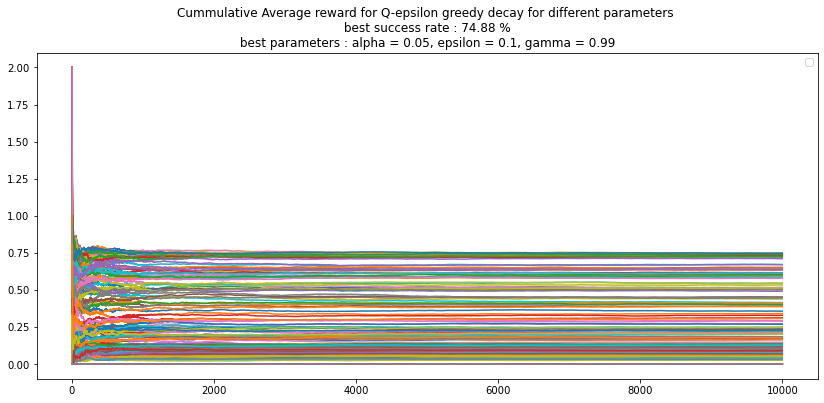

In [45]:
fig, axes = plt.subplots(figsize=(14, 6))
title = f"Cummulative Average reward for Q-epsilon greedy decay for different parameters \n best success rate : {round(100*df.iloc[0]['success_rate'],2)} % \n best parameters : alpha = {df.iloc[0]['alpha']}, epsilon = {df.iloc[0]['epsilon']}, gamma = {df.iloc[0]['gamma']} "
plt.title(title)
for i in range(len(df)):
    plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
plt.legend()
plt.show();

![images/output0.png](images/output0.png)

In [46]:
q_table_greedy_decay = q_train_greedy_decay(env_slip, alpha = 0.1, gamma = 0.99, min_epsilon=0.5)

Loading Q-table saved weights...
Error loading Q-table saved weights
Initiating new Q-table...
Starting Q-learning algorithm...


100%|██████████| 10000/10000 [00:07<00:00, 1327.37it/s]

Finished Q-learning algorithm.
Average reward is : 0.06


In [47]:
# SARSA optimization
alpha = [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 0.99]
gamma = [0.5, 0.8, 0.9, 0.95, 0.99, 1]
epsilon = [0.01, 0.05, 0.1, 0.5]
alphas=[]
success_rates = []
gammas=[]
epsilons=[]
rewards=[]
for al in alpha :
    for ga in gamma :
        for eps in epsilon :
            sarsa_table = sarsa_train(env_slip, al, ga, eps, episodes = 10000, steps = 100)
            reward, success_rate, avg_nb_steps = agent_play(env_slip, sarsa_table)
            success_rates.append(success_rate)
            alphas.append(al)
            gammas.append(ga)
            epsilons.append(eps)
            rewards.append(reward)


100%|██████████| 10000/10000 [00:01<00:00, 5034.43it/s]


Success rate is = 3.6700000000000004 %
Average number of steps before end (success or fall) = 9.6424


100%|██████████| 10000/10000 [00:02<00:00, 3918.73it/s]


Success rate is = 13.370000000000001 %
Average number of steps before end (success or fall) = 13.3416


100%|██████████| 10000/10000 [00:05<00:00, 1996.45it/s]


Success rate is = 44.47 %
Average number of steps before end (success or fall) = 27.4835


100%|██████████| 10000/10000 [00:02<00:00, 3672.38it/s]


Success rate is = 14.87 %
Average number of steps before end (success or fall) = 12.4823


100%|██████████| 10000/10000 [00:01<00:00, 7766.99it/s]


Success rate is = 2.68 %
Average number of steps before end (success or fall) = 6.0079


100%|██████████| 10000/10000 [00:01<00:00, 6154.16it/s]


Success rate is = 5.82 %
Average number of steps before end (success or fall) = 8.0639


100%|██████████| 10000/10000 [00:06<00:00, 1641.76it/s]


Success rate is = 38.17 %
Average number of steps before end (success or fall) = 29.8259


100%|██████████| 10000/10000 [00:04<00:00, 2349.78it/s]


Success rate is = 23.59 %
Average number of steps before end (success or fall) = 22.9847


100%|██████████| 10000/10000 [00:01<00:00, 5107.63it/s]


Success rate is = 7.580000000000001 %
Average number of steps before end (success or fall) = 10.1944


100%|██████████| 10000/10000 [00:02<00:00, 3562.79it/s]


Success rate is = 6.64 %
Average number of steps before end (success or fall) = 14.6822


100%|██████████| 10000/10000 [00:02<00:00, 3525.67it/s]


Success rate is = 4.68 %
Average number of steps before end (success or fall) = 14.7403


100%|██████████| 10000/10000 [00:04<00:00, 2326.86it/s]


Success rate is = 15.620000000000001 %
Average number of steps before end (success or fall) = 20.8752


100%|██████████| 10000/10000 [00:01<00:00, 6657.84it/s]


Success rate is = 3.52 %
Average number of steps before end (success or fall) = 7.3385


100%|██████████| 10000/10000 [00:05<00:00, 1962.91it/s]


Success rate is = 25.09 %
Average number of steps before end (success or fall) = 28.1575


100%|██████████| 10000/10000 [00:07<00:00, 1367.30it/s]


Success rate is = 60.57 %
Average number of steps before end (success or fall) = 35.8276


100%|██████████| 10000/10000 [00:04<00:00, 2134.99it/s]


Success rate is = 33.28 %
Average number of steps before end (success or fall) = 23.8343


100%|██████████| 10000/10000 [00:01<00:00, 8628.52it/s]


Success rate is = 1.5699999999999998 %
Average number of steps before end (success or fall) = 5.6561


100%|██████████| 10000/10000 [00:05<00:00, 1765.13it/s]


Success rate is = 32.96 %
Average number of steps before end (success or fall) = 30.391


100%|██████████| 10000/10000 [00:06<00:00, 1507.26it/s]


Success rate is = 59.85 %
Average number of steps before end (success or fall) = 36.0605


100%|██████████| 10000/10000 [00:06<00:00, 1660.24it/s]


Success rate is = 36.44 %
Average number of steps before end (success or fall) = 31.781


100%|██████████| 10000/10000 [00:01<00:00, 5832.38it/s]


Success rate is = 2.11 %
Average number of steps before end (success or fall) = 7.5227


100%|██████████| 10000/10000 [00:01<00:00, 7254.09it/s]


Success rate is = 4.65 %
Average number of steps before end (success or fall) = 6.2869


100%|██████████| 10000/10000 [00:09<00:00, 1055.28it/s]


Success rate is = 22.91 %
Average number of steps before end (success or fall) = 27.4723


100%|██████████| 10000/10000 [00:12<00:00, 771.76it/s]


Success rate is = 59.38 %
Average number of steps before end (success or fall) = 36.4191


100%|██████████| 10000/10000 [00:02<00:00, 3413.32it/s]


Success rate is = 4.02 %
Average number of steps before end (success or fall) = 5.7007


100%|██████████| 10000/10000 [00:03<00:00, 2644.34it/s]


Success rate is = 10.03 %
Average number of steps before end (success or fall) = 8.8141


100%|██████████| 10000/10000 [00:02<00:00, 4733.68it/s]


Success rate is = 5.7 %
Average number of steps before end (success or fall) = 7.242


100%|██████████| 10000/10000 [00:03<00:00, 2578.57it/s]


Success rate is = 13.200000000000001 %
Average number of steps before end (success or fall) = 15.825


100%|██████████| 10000/10000 [00:02<00:00, 4769.54it/s]


Success rate is = 6.239999999999999 %
Average number of steps before end (success or fall) = 10.2872


100%|██████████| 10000/10000 [00:05<00:00, 1724.11it/s]


Success rate is = 44.230000000000004 %
Average number of steps before end (success or fall) = 30.0975


100%|██████████| 10000/10000 [00:05<00:00, 1727.65it/s]


Success rate is = 37.419999999999995 %
Average number of steps before end (success or fall) = 30.1191


100%|██████████| 10000/10000 [00:04<00:00, 2176.75it/s]


Success rate is = 34.64 %
Average number of steps before end (success or fall) = 21.6076


100%|██████████| 10000/10000 [00:05<00:00, 1852.32it/s]


Success rate is = 15.64 %
Average number of steps before end (success or fall) = 27.3655


100%|██████████| 10000/10000 [00:06<00:00, 1471.17it/s]


Success rate is = 49.66 %
Average number of steps before end (success or fall) = 33.8707


100%|██████████| 10000/10000 [00:05<00:00, 1718.82it/s]


Success rate is = 51.470000000000006 %
Average number of steps before end (success or fall) = 30.5981


100%|██████████| 10000/10000 [00:02<00:00, 3868.22it/s]


Success rate is = 19.07 %
Average number of steps before end (success or fall) = 13.4413


100%|██████████| 10000/10000 [00:06<00:00, 1586.24it/s]


Success rate is = 39.68 %
Average number of steps before end (success or fall) = 33.9489


100%|██████████| 10000/10000 [00:07<00:00, 1310.38it/s]


Success rate is = 73.2 %
Average number of steps before end (success or fall) = 40.9841


100%|██████████| 10000/10000 [00:11<00:00, 850.61it/s]


Success rate is = 58.9 %
Average number of steps before end (success or fall) = 44.2413


100%|██████████| 10000/10000 [00:10<00:00, 931.39it/s]


Success rate is = 55.97 %
Average number of steps before end (success or fall) = 43.8028


100%|██████████| 10000/10000 [00:03<00:00, 3249.16it/s]


Success rate is = 11.49 %
Average number of steps before end (success or fall) = 12.5585


100%|██████████| 10000/10000 [00:07<00:00, 1266.13it/s]


Success rate is = 72.2 %
Average number of steps before end (success or fall) = 40.9885


100%|██████████| 10000/10000 [00:08<00:00, 1178.28it/s]


Success rate is = 72.47 %
Average number of steps before end (success or fall) = 41.307


100%|██████████| 10000/10000 [00:04<00:00, 2119.25it/s]


Success rate is = 15.160000000000002 %
Average number of steps before end (success or fall) = 21.9242


100%|██████████| 10000/10000 [00:05<00:00, 1678.18it/s]


Success rate is = 12.45 %
Average number of steps before end (success or fall) = 30.9013


100%|██████████| 10000/10000 [00:06<00:00, 1639.13it/s]


Success rate is = 21.19 %
Average number of steps before end (success or fall) = 27.9545


100%|██████████| 10000/10000 [00:07<00:00, 1306.74it/s]


Success rate is = 63.53 %
Average number of steps before end (success or fall) = 40.6152


100%|██████████| 10000/10000 [00:07<00:00, 1284.73it/s]


Success rate is = 64.51 %
Average number of steps before end (success or fall) = 41.1817


100%|██████████| 10000/10000 [00:04<00:00, 2300.34it/s]


Success rate is = 29.4 %
Average number of steps before end (success or fall) = 22.2399


100%|██████████| 10000/10000 [00:01<00:00, 6210.08it/s]


Success rate is = 5.09 %
Average number of steps before end (success or fall) = 5.4263


100%|██████████| 10000/10000 [00:02<00:00, 3702.79it/s]


Success rate is = 19.21 %
Average number of steps before end (success or fall) = 14.6311


100%|██████████| 10000/10000 [00:02<00:00, 4530.49it/s]


Success rate is = 3.5000000000000004 %
Average number of steps before end (success or fall) = 8.4507


100%|██████████| 10000/10000 [00:07<00:00, 1371.87it/s]


Success rate is = 56.13 %
Average number of steps before end (success or fall) = 35.95


100%|██████████| 10000/10000 [00:02<00:00, 3775.39it/s]


Success rate is = 13.950000000000001 %
Average number of steps before end (success or fall) = 11.4319


100%|██████████| 10000/10000 [00:05<00:00, 1677.97it/s]


Success rate is = 51.31 %
Average number of steps before end (success or fall) = 30.9994


100%|██████████| 10000/10000 [00:02<00:00, 3807.27it/s]


Success rate is = 12.45 %
Average number of steps before end (success or fall) = 13.2401


100%|██████████| 10000/10000 [00:07<00:00, 1314.16it/s]


Success rate is = 61.21 %
Average number of steps before end (success or fall) = 39.2655


100%|██████████| 10000/10000 [00:05<00:00, 1732.27it/s]


Success rate is = 44.92 %
Average number of steps before end (success or fall) = 30.2273


100%|██████████| 10000/10000 [00:06<00:00, 1552.92it/s]


Success rate is = 51.300000000000004 %
Average number of steps before end (success or fall) = 30.8473


100%|██████████| 10000/10000 [00:07<00:00, 1386.21it/s]


Success rate is = 67.86 %
Average number of steps before end (success or fall) = 37.7724


100%|██████████| 10000/10000 [00:07<00:00, 1255.76it/s]


Success rate is = 72.45 %
Average number of steps before end (success or fall) = 41.3827


100%|██████████| 10000/10000 [00:08<00:00, 1205.58it/s]


Success rate is = 72.99 %
Average number of steps before end (success or fall) = 41.1907


100%|██████████| 10000/10000 [00:07<00:00, 1342.75it/s]


Success rate is = 67.25 %
Average number of steps before end (success or fall) = 37.8872


100%|██████████| 10000/10000 [00:02<00:00, 3604.68it/s]


Success rate is = 15.040000000000001 %
Average number of steps before end (success or fall) = 13.7806


100%|██████████| 10000/10000 [00:08<00:00, 1113.27it/s]


Success rate is = 73.55000000000001 %
Average number of steps before end (success or fall) = 41.2627


100%|██████████| 10000/10000 [00:08<00:00, 1165.39it/s]


Success rate is = 73.88 %
Average number of steps before end (success or fall) = 44.7813


100%|██████████| 10000/10000 [00:07<00:00, 1268.46it/s]


Success rate is = 71.97 %
Average number of steps before end (success or fall) = 41.9072


100%|██████████| 10000/10000 [00:02<00:00, 3562.18it/s]


Success rate is = 20.46 %
Average number of steps before end (success or fall) = 13.8373


100%|██████████| 10000/10000 [00:08<00:00, 1140.14it/s]


Success rate is = 71.48 %
Average number of steps before end (success or fall) = 40.4355


100%|██████████| 10000/10000 [00:08<00:00, 1197.37it/s]


Success rate is = 72.69 %
Average number of steps before end (success or fall) = 41.383


100%|██████████| 10000/10000 [00:08<00:00, 1244.02it/s]


Success rate is = 72.76 %
Average number of steps before end (success or fall) = 41.4011


100%|██████████| 10000/10000 [00:07<00:00, 1309.70it/s]


Success rate is = 58.79 %
Average number of steps before end (success or fall) = 36.233


100%|██████████| 10000/10000 [00:01<00:00, 5065.65it/s]


Success rate is = 11.67 %
Average number of steps before end (success or fall) = 7.3105


100%|██████████| 10000/10000 [00:01<00:00, 5811.32it/s]


Success rate is = 9.65 %
Average number of steps before end (success or fall) = 8.7544


100%|██████████| 10000/10000 [00:01<00:00, 6248.08it/s]


Success rate is = 4.0 %
Average number of steps before end (success or fall) = 7.3877


100%|██████████| 10000/10000 [00:01<00:00, 8857.33it/s]


Success rate is = 3.64 %
Average number of steps before end (success or fall) = 5.4399


100%|██████████| 10000/10000 [00:02<00:00, 3817.82it/s]


Success rate is = 17.51 %
Average number of steps before end (success or fall) = 12.1201


100%|██████████| 10000/10000 [00:05<00:00, 1886.72it/s]


Success rate is = 24.16 %
Average number of steps before end (success or fall) = 24.2954


100%|██████████| 10000/10000 [00:08<00:00, 1229.84it/s]


Success rate is = 69.93 %
Average number of steps before end (success or fall) = 39.6876


100%|██████████| 10000/10000 [00:06<00:00, 1530.68it/s]


Success rate is = 20.1 %
Average number of steps before end (success or fall) = 35.0392


100%|██████████| 10000/10000 [00:04<00:00, 2284.72it/s]


Success rate is = 25.95 %
Average number of steps before end (success or fall) = 21.9593


100%|██████████| 10000/10000 [00:05<00:00, 1759.70it/s]


Success rate is = 22.12 %
Average number of steps before end (success or fall) = 29.4736


100%|██████████| 10000/10000 [00:08<00:00, 1242.39it/s]


Success rate is = 21.349999999999998 %
Average number of steps before end (success or fall) = 37.274


100%|██████████| 10000/10000 [00:01<00:00, 8165.20it/s]


Success rate is = 6.65 %
Average number of steps before end (success or fall) = 5.9549


100%|██████████| 10000/10000 [00:08<00:00, 1241.49it/s]


Success rate is = 70.55 %
Average number of steps before end (success or fall) = 40.3319


100%|██████████| 10000/10000 [00:08<00:00, 1218.93it/s]


Success rate is = 72.97 %
Average number of steps before end (success or fall) = 41.2493


100%|██████████| 10000/10000 [00:07<00:00, 1410.29it/s]


Success rate is = 44.1 %
Average number of steps before end (success or fall) = 35.8516


100%|██████████| 10000/10000 [00:02<00:00, 3889.20it/s]


Success rate is = 20.76 %
Average number of steps before end (success or fall) = 12.9637


100%|██████████| 10000/10000 [00:09<00:00, 1109.14it/s]


Success rate is = 74.15 %
Average number of steps before end (success or fall) = 44.6619


100%|██████████| 10000/10000 [00:09<00:00, 1089.52it/s]


Success rate is = 70.28 %
Average number of steps before end (success or fall) = 40.4745


100%|██████████| 10000/10000 [00:09<00:00, 1029.51it/s]


Success rate is = 58.86 %
Average number of steps before end (success or fall) = 50.1223


100%|██████████| 10000/10000 [00:01<00:00, 5099.35it/s]


Success rate is = 8.84 %
Average number of steps before end (success or fall) = 9.5118


100%|██████████| 10000/10000 [00:10<00:00, 973.90it/s]


Success rate is = 73.52 %
Average number of steps before end (success or fall) = 44.6591


100%|██████████| 10000/10000 [00:08<00:00, 1217.54it/s]


Success rate is = 72.81 %
Average number of steps before end (success or fall) = 41.7333


100%|██████████| 10000/10000 [00:04<00:00, 2161.46it/s]


Success rate is = 6.239999999999999 %
Average number of steps before end (success or fall) = 21.7834


100%|██████████| 10000/10000 [00:02<00:00, 4196.39it/s]


Success rate is = 4.36 %
Average number of steps before end (success or fall) = 11.2947


100%|██████████| 10000/10000 [00:05<00:00, 1710.76it/s]


Success rate is = 44.74 %
Average number of steps before end (success or fall) = 30.2312


100%|██████████| 10000/10000 [00:05<00:00, 1730.93it/s]


Success rate is = 19.96 %
Average number of steps before end (success or fall) = 30.0579


100%|██████████| 10000/10000 [00:03<00:00, 2518.21it/s]


Success rate is = 8.93 %
Average number of steps before end (success or fall) = 20.1293


100%|██████████| 10000/10000 [00:01<00:00, 6932.94it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 5.977


100%|██████████| 10000/10000 [00:08<00:00, 1238.67it/s]


Success rate is = 70.21 %
Average number of steps before end (success or fall) = 40.4719


100%|██████████| 10000/10000 [00:04<00:00, 2164.57it/s]


Success rate is = 28.48 %
Average number of steps before end (success or fall) = 23.5682


100%|██████████| 10000/10000 [00:01<00:00, 5444.62it/s]


Success rate is = 9.370000000000001 %
Average number of steps before end (success or fall) = 9.0533


100%|██████████| 10000/10000 [00:01<00:00, 5057.86it/s]


Success rate is = 7.489999999999999 %
Average number of steps before end (success or fall) = 8.8086


100%|██████████| 10000/10000 [00:07<00:00, 1254.81it/s]


Success rate is = 70.97 %
Average number of steps before end (success or fall) = 40.6789


100%|██████████| 10000/10000 [00:09<00:00, 1073.99it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 47.3011


100%|██████████| 10000/10000 [00:07<00:00, 1307.58it/s]


Success rate is = 61.4 %
Average number of steps before end (success or fall) = 39.3541


100%|██████████| 10000/10000 [00:01<00:00, 5263.07it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 8.9464


100%|██████████| 10000/10000 [00:03<00:00, 2879.33it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 17.9942


100%|██████████| 10000/10000 [00:03<00:00, 2866.03it/s]


Success rate is = 23.86 %
Average number of steps before end (success or fall) = 15.9873


100%|██████████| 10000/10000 [00:05<00:00, 1699.68it/s]


Success rate is = 32.79 %
Average number of steps before end (success or fall) = 27.7416


100%|██████████| 10000/10000 [00:04<00:00, 2256.90it/s]


Success rate is = 25.56 %
Average number of steps before end (success or fall) = 23.4846


100%|██████████| 10000/10000 [00:03<00:00, 3131.23it/s]


Success rate is = 27.41 %
Average number of steps before end (success or fall) = 15.7815


100%|██████████| 10000/10000 [00:02<00:00, 3930.56it/s]


Success rate is = 5.609999999999999 %
Average number of steps before end (success or fall) = 12.9473


100%|██████████| 10000/10000 [00:05<00:00, 1824.52it/s]


Success rate is = 17.96 %
Average number of steps before end (success or fall) = 27.9923


100%|██████████| 10000/10000 [00:02<00:00, 4032.12it/s]


Success rate is = 11.51 %
Average number of steps before end (success or fall) = 11.485


100%|██████████| 10000/10000 [00:04<00:00, 2089.88it/s]


Success rate is = 25.09 %
Average number of steps before end (success or fall) = 24.6384


100%|██████████| 10000/10000 [00:06<00:00, 1464.97it/s]


Success rate is = 32.12 %
Average number of steps before end (success or fall) = 30.8029


100%|██████████| 10000/10000 [00:02<00:00, 3542.54it/s]


Success rate is = 21.59 %
Average number of steps before end (success or fall) = 14.5536


100%|██████████| 10000/10000 [00:01<00:00, 7263.01it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 6.0221


100%|██████████| 10000/10000 [00:02<00:00, 4369.05it/s]


Success rate is = 15.42 %
Average number of steps before end (success or fall) = 11.3817


100%|██████████| 10000/10000 [00:03<00:00, 2656.00it/s]


Success rate is = 16.89 %
Average number of steps before end (success or fall) = 18.8803


100%|██████████| 10000/10000 [00:01<00:00, 6082.85it/s]


Success rate is = 3.9800000000000004 %
Average number of steps before end (success or fall) = 8.4058


100%|██████████| 10000/10000 [00:01<00:00, 5656.59it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 8.5337


100%|██████████| 10000/10000 [00:07<00:00, 1264.04it/s]


Success rate is = 72.57000000000001 %
Average number of steps before end (success or fall) = 41.9031


100%|██████████| 10000/10000 [00:06<00:00, 1480.44it/s]


Success rate is = 59.29 %
Average number of steps before end (success or fall) = 35.8945


100%|██████████| 10000/10000 [00:04<00:00, 2321.05it/s]


Success rate is = 18.9 %
Average number of steps before end (success or fall) = 21.6996


100%|██████████| 10000/10000 [00:19<00:00, 512.64it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0


100%|██████████| 10000/10000 [00:08<00:00, 1227.09it/s]


Success rate is = 63.88 %
Average number of steps before end (success or fall) = 40.6159


100%|██████████| 10000/10000 [00:01<00:00, 5647.61it/s]


Success rate is = 4.99 %
Average number of steps before end (success or fall) = 8.6914


100%|██████████| 10000/10000 [00:02<00:00, 4281.79it/s]


Success rate is = 6.5 %
Average number of steps before end (success or fall) = 12.0879


100%|██████████| 10000/10000 [00:02<00:00, 4170.85it/s]


Success rate is = 7.95 %
Average number of steps before end (success or fall) = 12.9322


100%|██████████| 10000/10000 [00:08<00:00, 1130.81it/s]


Success rate is = 74.35000000000001 %
Average number of steps before end (success or fall) = 43.9788


100%|██████████| 10000/10000 [00:09<00:00, 1080.69it/s]


Success rate is = 74.88 %
Average number of steps before end (success or fall) = 44.214


100%|██████████| 10000/10000 [00:02<00:00, 4436.08it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 8.8972


100%|██████████| 10000/10000 [00:01<00:00, 5899.59it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 7.444


100%|██████████| 10000/10000 [00:19<00:00, 522.24it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0


100%|██████████| 10000/10000 [00:07<00:00, 1416.30it/s]


Success rate is = 48.93 %
Average number of steps before end (success or fall) = 35.9169


100%|██████████| 10000/10000 [00:04<00:00, 2216.76it/s]


Success rate is = 29.04 %
Average number of steps before end (success or fall) = 22.8664


100%|██████████| 10000/10000 [00:02<00:00, 4568.33it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 8.9195


100%|██████████| 10000/10000 [00:09<00:00, 1092.44it/s]


Success rate is = 73.94 %
Average number of steps before end (success or fall) = 44.2089


100%|██████████| 10000/10000 [00:05<00:00, 1701.94it/s]


Success rate is = 6.05 %
Average number of steps before end (success or fall) = 29.3166


100%|██████████| 10000/10000 [00:04<00:00, 2363.76it/s]


Success rate is = 25.56 %
Average number of steps before end (success or fall) = 21.783


100%|██████████| 10000/10000 [00:04<00:00, 2159.44it/s]


Success rate is = 19.24 %
Average number of steps before end (success or fall) = 21.0242


100%|██████████| 10000/10000 [00:04<00:00, 2296.70it/s]


Success rate is = 31.0 %
Average number of steps before end (success or fall) = 20.8885


100%|██████████| 10000/10000 [00:02<00:00, 3361.55it/s]


Success rate is = 17.95 %
Average number of steps before end (success or fall) = 14.0534


100%|██████████| 10000/10000 [00:02<00:00, 3977.91it/s]


Success rate is = 6.2700000000000005 %
Average number of steps before end (success or fall) = 12.4844


100%|██████████| 10000/10000 [00:01<00:00, 5875.87it/s]


Success rate is = 7.46 %
Average number of steps before end (success or fall) = 7.8265


100%|██████████| 10000/10000 [00:06<00:00, 1565.25it/s]


Success rate is = 24.83 %
Average number of steps before end (success or fall) = 28.6545


100%|██████████| 10000/10000 [00:05<00:00, 1844.78it/s]


Success rate is = 21.21 %
Average number of steps before end (success or fall) = 27.7778


100%|██████████| 10000/10000 [00:04<00:00, 2385.45it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 19.1711


100%|██████████| 10000/10000 [00:02<00:00, 3662.89it/s]


Success rate is = 2.34 %
Average number of steps before end (success or fall) = 9.1451


100%|██████████| 10000/10000 [00:08<00:00, 1149.18it/s]


Success rate is = 61.809999999999995 %
Average number of steps before end (success or fall) = 39.086


100%|██████████| 10000/10000 [00:06<00:00, 1493.11it/s]


Success rate is = 22.09 %
Average number of steps before end (success or fall) = 32.5176


100%|██████████| 10000/10000 [00:08<00:00, 1154.49it/s]


Success rate is = 58.5 %
Average number of steps before end (success or fall) = 45.1286


100%|██████████| 10000/10000 [00:02<00:00, 4858.40it/s]


Success rate is = 7.8 %
Average number of steps before end (success or fall) = 8.7281


100%|██████████| 10000/10000 [00:01<00:00, 5372.86it/s]


Success rate is = 9.42 %
Average number of steps before end (success or fall) = 9.2569


100%|██████████| 10000/10000 [00:02<00:00, 3432.33it/s]


Success rate is = 22.1 %
Average number of steps before end (success or fall) = 14.645


100%|██████████| 10000/10000 [00:07<00:00, 1323.48it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 37.8588


100%|██████████| 10000/10000 [00:05<00:00, 1745.67it/s]


Success rate is = 13.41 %
Average number of steps before end (success or fall) = 29.0168


100%|██████████| 10000/10000 [00:10<00:00, 966.26it/s]


Success rate is = 58.79 %
Average number of steps before end (success or fall) = 49.5639


100%|██████████| 10000/10000 [00:08<00:00, 1135.21it/s]


Success rate is = 58.78 %
Average number of steps before end (success or fall) = 45.1381


100%|██████████| 10000/10000 [00:01<00:00, 5809.19it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 8.8791


100%|██████████| 10000/10000 [00:06<00:00, 1525.40it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 29.8537


100%|██████████| 10000/10000 [00:12<00:00, 829.72it/s]


Success rate is = 54.82 %
Average number of steps before end (success or fall) = 62.5503


100%|██████████| 10000/10000 [00:06<00:00, 1567.57it/s]


Success rate is = 20.5 %
Average number of steps before end (success or fall) = 30.1077


100%|██████████| 10000/10000 [00:04<00:00, 2289.70it/s]


Success rate is = 21.67 %
Average number of steps before end (success or fall) = 20.2421


100%|██████████| 10000/10000 [00:02<00:00, 4435.93it/s]

Success rate is = 6.18 %
Average number of steps before end (success or fall) = 10.3969


In [48]:
df = pd.DataFrame()

df["epsilon"]=epsilons
df["alpha"]=alphas
df["gamma"]=gammas
df["success_rate"]=success_rates
df = df.sort_values(by="success_rate", ascending=False)
df

,epsilon,alpha,gamma,success_rate
133,0.05,0.90,0.95,0.7488
132,0.01,0.90,0.95,0.7435
88,0.01,0.50,0.99,0.7415
140,0.01,0.90,1.00,0.7394
65,0.05,0.10,0.99,0.7388
...,...,...,...,...
119,0.50,0.80,1.00,0.0000
108,0.01,0.80,0.95,0.0000
134,0.10,0.90,0.95,0.0000
107,0.50,0.80,0.90,0.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


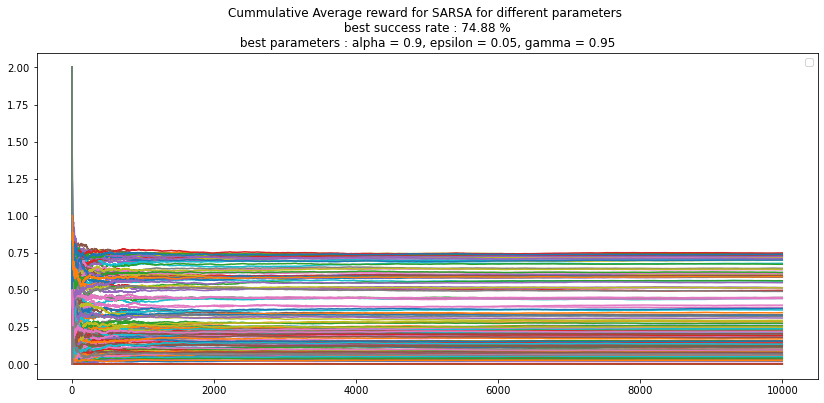

In [49]:
fig, axes = plt.subplots(figsize=(14, 6))
title = f"Cummulative Average reward for SARSA for different parameters \n best success rate : {round(100*df.iloc[0]['success_rate'],2)} % \n best parameters : alpha = {df.iloc[0]['alpha']}, epsilon = {df.iloc[0]['epsilon']}, gamma = {df.iloc[0]['gamma']} "
plt.title(title)
for i in range(len(df)):
    plt.plot(np.arange(len(rewards[i])), np.cumsum(rewards[i])/np.arange(len(rewards[i])))
plt.legend()
plt.show()

![images/output.png](images/output.png)

In [50]:
sarsa_table = sarsa_train(env_slip, alpha = 0.1, gamma = 0.99, epsilon = 0.1, episodes = 10000, steps = 100)

100%|██████████| 10000/10000 [00:19<00:00, 520.97it/s]


Recalculting the performances...

In [51]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env_slip, q_table=deterministic_q_table)
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env_slip, q_table=q_table)
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env_slip, q_table=q_table_greedy)
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env_slip, q_table=q_table_greedy_decay)
rewards_sarsa, success_rate_sarsa, avg_num_steps_sarsa= agent_play(env_slip, q_table=sarsa_table)

100%|██████████| 10000/10000 [00:01<00:00, 6786.09it/s]


Success rate is = 4.6 %
Average number of steps before end (success or fall) = 5.0582


100%|██████████| 10000/10000 [00:22<00:00, 451.58it/s]


Success rate is = 0.0 %
Average number of steps before end (success or fall) = 100.0


100%|██████████| 10000/10000 [00:01<00:00, 6515.66it/s]


Success rate is = 3.62 %
Average number of steps before end (success or fall) = 7.3836


100%|██████████| 10000/10000 [00:13<00:00, 725.58it/s]


Success rate is = 48.96 %
Average number of steps before end (success or fall) = 63.4323


100%|██████████| 10000/10000 [00:07<00:00, 1426.91it/s]

Success rate is = 60.029999999999994 %
Average number of steps before end (success or fall) = 36.2349


As we can, the performances of both the $\epsilon$-greedy decay Q-learning algorithm and the SARSA algorithm have been increased.

### 3.3. Comparison

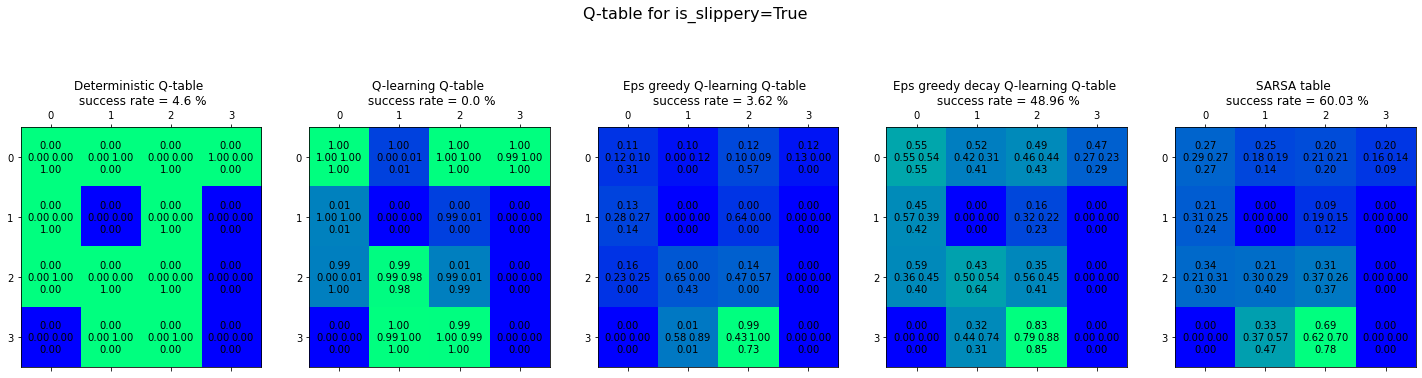

In [52]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(25, 7)
# im = Image.open('images/frozen_lake.jpg')
fig.suptitle("Q-table for is_slippery=True", fontsize=16)

# Creating the heat maps
map_q = np.sum(q_table, axis = 1)
map_q= map_q.reshape(4, 4)

map_d = np.sum(deterministic_q_table, axis = 1)
map_d= map_d.reshape(4, 4)

map_g = np.sum(q_table_greedy, axis = 1)
map_g= map_g.reshape(4, 4)

map_e = np.sum(q_table_greedy_decay, axis = 1)
map_e= map_e.reshape(4, 4)

map_s = np.sum(sarsa_table, axis = 1)
map_s= map_s.reshape(4, 4)


# ax[0].imshow(im, alpha=1)
# ax[1].imshow(im, alpha=1)

ax[0].matshow(map_d, cmap='winter')
ax[1].matshow(map_q, cmap='winter')
ax[2].matshow(map_g, cmap='winter')
ax[3].matshow(map_e, cmap='winter')
ax[4].matshow(map_s, cmap='winter')

pos=[0,1,2,3]

deterministic_q_table_reshaped=deterministic_q_table.reshape((4,4,4))
q_table_reshaped=q_table.reshape((4,4,4))
greedy_reshaped=q_table_greedy.reshape((4,4,4))
q_table_greedy_decay_reshaped =q_table_greedy_decay.reshape((4,4,4))
sarsa_reshaped =sarsa_table.reshape((4,4,4))


deviation = 0.2
for i in pos: # rows
    for j in pos: # cols

        ax[0].text(j-deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[0].text(j, i+deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[0].text(j+deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[0].text(j, i-deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[0].set_title(f"Deterministic Q-table \n success rate = {round(100*success_rate_d,2)} %")

        ax[1].text(j-deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[1].text(j, i+deviation, '{:0.2f}'.format(q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[1].text(j+deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[1].text(j, i-deviation, '{:0.2f}'.format(q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[1].set_title(f"Q-learning Q-table \n success rate = {round(100*success_rate_q,2)} %")

        ax[2].text(j-deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[2].text(j, i+deviation, '{:0.2f}'.format(greedy_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[2].text(j+deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[2].text(j, i-deviation, '{:0.2f}'.format(greedy_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[2].set_title(f"Eps greedy Q-learning Q-table  \n success rate = {round(100*success_rate_q_greedy,2)} %")


        ax[3].text(j-deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[3].text(j, i+deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[3].text(j+deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[3].text(j, i-deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[3].set_title(f"Eps greedy decay Q-learning Q-table \n success rate = {round(100*success_rate_q_greedy_decay,2)} %")

        ax[4].text(j-deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[4].text(j, i+deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[4].text(j+deviation, i, '{:0.2f}'.format(sarsa_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[4].text(j, i-deviation, '{:0.2f}'.format(sarsa_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[4].set_title(f"SARSA table \n success rate = {round(100*success_rate_sarsa,2)} %")
plt.show()

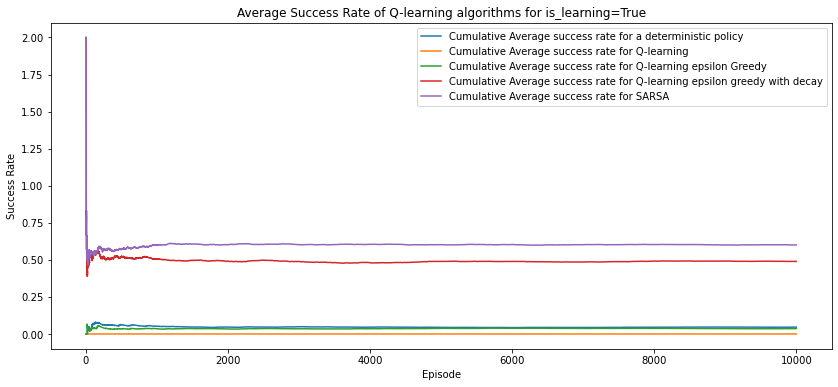

In [53]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-learning epsilon greedy with decay")
plt.plot(np.arange(len(rewards_sarsa)), np.cumsum(rewards_sarsa)/np.arange(len(rewards_sarsa)), label="Cumulative Average success rate for SARSA")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Success Rate of Q-learning algorithms for is_learning=True')
plt.legend()
plt.show()

## 4. Conclusion :
We've established 3 variations of the Q-learning algorithm. As well as the SARSA algorithm, we've benchmarked their performance for both `slippery` and `non-slippery` environments. Furthermore, we've optimized their performance through a manual grid search of the hyperparameters.